# Kernels for hand-made SVM

**In this homework we will again look at SVM kernels and will write and test rbf kernel for our own implementation.**

In [27]:
'''
If you are using Google Colab, uncomment the next line to download `svm.py`
You can open and change downloaded `.py` files in Colab using the "Files" sidebar on the left.
'''
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/assignment0_03_svm/svm.py 

'\nIf you are using Google Colab, uncomment the next line to download `svm.py`\nYou can open and change downloaded `.py` files in Colab using the "Files" sidebar on the left.\n'

In [28]:
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
import numpy as np
from sklearn.metrics import accuracy_score

In [29]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for our SVM class"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.predict(xy).reshape(X.shape)
    # plot decision boundary and margins
    CS = ax.contourf(X, Y, P, origin='lower', cmap='autumn', alpha=0.1)
    plt.colorbar(CS, ax=ax, shrink=0.8, extend='both')
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [30]:
from sklearn.datasets import make_circles

from sklearn.svm import SVC # "Support vector classifier"

X, y = make_circles(150, factor=.1, noise=.1, random_state=42)

X_test, y_test = X[100:], y[100:]
X, y = X[:100], y[:100]

### Sklearn realization:

Test accuracy:  0.64


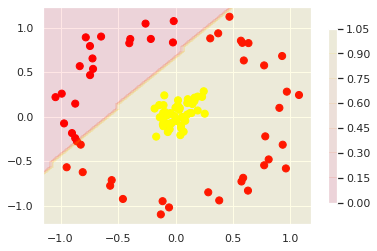

In [31]:
clf = SVC(kernel='linear').fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Test accuracy:  1.0


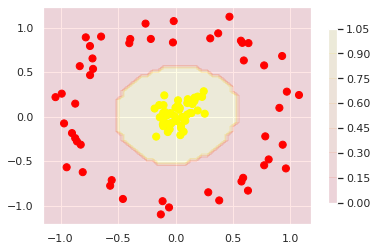

In [32]:
clf = SVC(kernel='rbf').fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

## Let's look at our realization

### You need to open svm.py file and add all missed lines.

Linear SVM __primal__ optimization problem can be formulated as

$$ \frac{1}{n} \sum_{i=1}^n \max(0, 1 - y_i (w X_i - b)) + \lambda ||w||_2 \to \min_w $$

This problem can be solved with gradient or sub-gradien methods.

-----
Whereas __dual__ optimization problem formulates as follows:

$$
\sum_{i=1}^n c_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i c_i (X_i \cdot X_j ) y_j c_j \to \max_{c_1,...,c_n} \\ \text{subject to} \\
\sum_{i=1}^n c_iy_i=0 \\
0 \leq c_i \leq \frac{1}{2n\lambda} \forall i
$$

Where $W = \sum_{i=1}^n c_i y_i X_i$.

In this quadratic optimization problem we can use kernel trick: <br/>
introduce fucntion $K(X_i, X_j) = \phi (X_i) \phi (X_j)$ and change dot products in our optimization problem

Then we have 

$$
\sum_{i=1}^n c_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n y_i c_i K(X_i, X_j) y_j c_j \to \max_{c_1,...,c_n} \\
\text{subject to} \\
\sum_{i=1}^n c_iy_i=0 \\
0 \leq c_i \leq \frac{1}{2n\lambda} \forall i
$$

$W = \sum_{i=1}^n c_i y_i \phi(X_i)$

In quadratic programming we can straightforwardly add kernel function, but it is not that simple, if we want to use gradient algorithms.

----
However primal optimization problem with kernels can be formulated like (see [Olivier Chapelle, 2006](https://www.cs.utah.edu/~piyush/teaching/svm-solving-primal.pdf)):

$$f(x) = \sum_{i=1}^n \beta_i K(x_i, x)$$

$$K: K_{i,j} = K(x_i, x_j)$$

$$ \lambda \vec{\beta^T} K \vec{\beta} + \sum_{i=1}^n L(y_i, K_i^T \vec{\beta}) \to \min_{\vec{\beta}}$$

where L is Hinge loss: $L(y_i, K_i^T \vec{\beta}) = \max(0, 1 - y_i (K_i^T \vec{\beta}))$

#### Radial basis function kernel.

####  The RBF kernel on two samples x and x', represented as feature vectors in some input space, is defined as:

## $K(x,x') = \exp \big{[}- \frac{||x-x'||^2}{2 \sigma^2} \big{]}.$

### Let's look how it works:

In [33]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


def rbf(x_1, x_2, sigma=1.):
    '''Computes rbf kernel for batches of objects

    Args:
        x_1: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
        x_2: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
    Returns:
        kernel function values for all pairs of samples from x_1 and x_2
        torch.tensor of type torch.float32 shaped `(#samples_1, #samples_2)`
    '''
    size = (x_1.size(0), x_2.size(0), x_1.size(1))
    distances = torch.exp(-(torch.pow(
        (x_1.unsqueeze(1).expand(size) 
        - x_2.unsqueeze(0).expand(size)), 2).sum(2)) / (2 * sigma**2))
    
    return torch.Tensor(distances).type(torch.float32)

def hinge_loss(scores, labels):
    '''Mean loss for batch of objects
    '''
    assert len(scores.shape) == 1
    assert len(labels.shape) == 1

    return torch.clamp((1 - scores * labels), 0).mean()


class SVM(BaseEstimator, ClassifierMixin):
    @staticmethod
    def linear(x_1, x_2):
        '''Computes linear kernel for batches of objects
        
        Args:
            x_1: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
            x_2: torch.tensor shaped `(#samples_1, #features)` of type torch.float32
        Returns:
            kernel function values for all pairs of samples from x_1 and x_2
            torch.tensor shaped `(#samples_1, #samples_2)` of type torch.float32
        '''
        return x_1 @ x_2.T### YOUR CODE HERE
    
    def __init__(
        self,
        lr: float=1e-3,
        epochs: int=2,
        batch_size: int=64,
        lmbd: float=1e-4,
        kernel_function=None,
        verbose: bool=False,
    ):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lmbd = lmbd
        self.kernel_function = kernel_function or SVM.linear
        self.verbose = verbose
        self.fitted = False

    def __repr__(self):
        return 'SVM model, fitted: {self.fitted}'

    def fit(self, X, Y):
        assert (np.abs(Y) == 1).all()
        n_obj = len(X)
        X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)
        K = self.kernel_function(X, X).float()

        self.betas = torch.full((n_obj, 1), fill_value=0.001, dtype=X.dtype, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True) # I've also add bias to the model
        
        optimizer = optim.SGD((self.betas, self.bias), lr=self.lr)
        for epoch in range(self.epochs):
            perm = torch.randperm(n_obj)  # Generate a set of random numbers of length: sample size
            sum_loss = 0.                 # Loss for each epoch
            for i in range(0, n_obj, self.batch_size):
                batch_inds = perm[i:i + self.batch_size]
                x_batch = X[batch_inds]   # Pick random samples by iterating over random permutation
                y_batch = Y[batch_inds]   # Pick the correlating class
                k_batch = K[batch_inds]
                
                optimizer.zero_grad()     # Manually zero the gradient buffers of the optimizer
                
                preds = k_batch @ self.betas - self.bias### YOUR CODE HERE # get the matrix product using SVM parameters: self.betas and self.bias
                preds = preds.flatten()
                loss = self.lmbd * self.betas[batch_inds].T @ k_batch @ self.betas + hinge_loss(preds, y_batch)
                loss.backward()           # Backpropagation
                optimizer.step()          # Optimize and adjust weights

                sum_loss += loss.item()   # Add the loss

            if self.verbose: print("Epoch " + str(epoch) + ", Loss: " + str(sum_loss / self.batch_size))

        self.X = X
        self.fitted = True
        return self

    def predict_scores(self, batch):
        with torch.no_grad():
            batch = torch.from_numpy(batch).float()
            K = self.kernel_function(batch, self.X)
            # compute the margin values for every object in the batch
            return (K @ self.betas - self.bias).flatten()### YOUR CODE HERE

    def predict(self, batch):
        scores = self.predict_scores(batch)
        answers = np.full(len(batch), -1, dtype=np.int64)
        answers[scores > 0] = 1
        return answers

In [34]:
y[y==0] = -1 # for convenience with formulas
y_test[y_test==0] = -1

Epoch 0, Loss: 0.2644245535135269
Epoch 1, Loss: 0.32559880018234255
Epoch 2, Loss: 0.2875701397657394
Test accuracy:  0.7


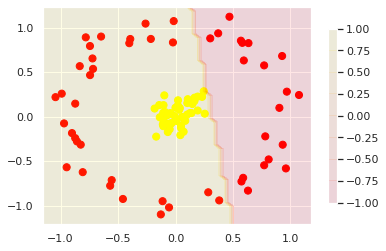

In [35]:
clf = SVM(epochs=3, lr=1, batch_size=20, verbose=True)
clf.fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Epoch 0, Loss: 0.2796160876750946
Epoch 1, Loss: 0.23504654169082642
Epoch 2, Loss: 0.2640369385480881
Epoch 3, Loss: 0.2485634505748749
Epoch 4, Loss: 0.22736888527870178
Epoch 5, Loss: 0.19038599729537964
Epoch 6, Loss: 0.1657959282398224
Epoch 7, Loss: 0.20813988745212555
Epoch 8, Loss: 0.18064657747745513
Epoch 9, Loss: 0.22726784348487855
Epoch 10, Loss: 0.2430023729801178
Epoch 11, Loss: 0.1730331987142563
Epoch 12, Loss: 0.1475236162543297
Epoch 13, Loss: 0.16299838721752166
Epoch 14, Loss: 0.12006897032260895
Epoch 15, Loss: 0.18839121460914612
Epoch 16, Loss: 0.14754432290792466
Epoch 17, Loss: 0.14134675338864328
Epoch 18, Loss: 0.157705657184124
Epoch 19, Loss: 0.11349969133734703
Epoch 20, Loss: 0.14120360165834428
Epoch 21, Loss: 0.20064114555716514
Epoch 22, Loss: 0.15051335766911506
Epoch 23, Loss: 0.08658992871642113
Epoch 24, Loss: 0.084766086935997
Epoch 25, Loss: 0.15716971606016159
Epoch 26, Loss: 0.11348104625940322
Epoch 27, Loss: 0.11629242114722729
Epoch 28, Los

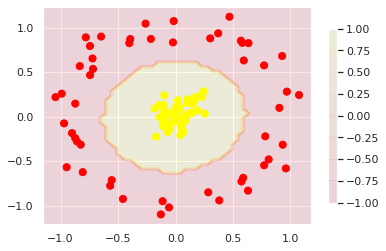

In [36]:
clf = SVM(epochs=100, lr=0.1, batch_size=20, verbose=True, kernel_function=rbf)
clf.fit(X, y)
pred = clf.predict(X_test)
print("Test accuracy: ", accuracy_score(y_test, pred))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [37]:
accuracy_score(y_test, pred)

1.0

In [38]:
assert accuracy_score(y_test, pred) > 0.95

## Our model with rbf kernel can learn this dataset too.